In [1]:
import os
if os.getcwd().split("/")[-1] != "neurolib":
    os.chdir('..')

os.chdir('..')
datadir = os.path.join(os.getcwd(), "neurolib", "notebooks_frontiers24")

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from numba.typed import Dict
from numba.core import types

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel

from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln, cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

def plot_control(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0].plot(time_array, s[n,0,:], color="red")
        ax[1].plot(time_array, c[n,0,:], color="red")
        ax[1].plot(time_array, c[n,1,:], color="blue")

    ax[0].set_xlim(0, dur)

    ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state

# This function sets the initial state of a model to specific values
def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

# This function reads the complete state of the EIF model
def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

def getperiod(data, dt):

    for i_d,d in enumerate(data):
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_plot[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))

    return (1./fr[maxfreqind])[0]

def adjust_weight(model_controlled, weight):
    coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)
    fsync = (model_controlled.compute_total_cost() - coc)/weight
    weight = (-1e-12 - coc)/fsync # adjust weight such that cost remains negative
    print("weight = ", weight)
    model_controlled.weights["w_f_osc"] = weight
    return weight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = dict()
coords = [1.9, 1.5]

data = dict()
data["coordinates"] = coords
data["control"] = [None, None]
data["state"] = [None, None]
data["init_state"] = [None, None]
data["energy_input"] = np.zeros((2))
data["Fourier_cost"] = np.zeros((2))
data["weights"] = np.zeros((2))

N = 1
model = ALNModel()
dt = model.params.dt

In [4]:
model = ALNModel()
testd = 2.*1e4
model.params.duration = testd
model.params.mue_ext_mean = data["coordinates"][0]
model.params.mui_ext_mean = data["coordinates"][1]

test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
test_input[0,int(2000/dt):int(2010/dt)] = -1.
model.params["ext_exc_current"] = test_input
model.params["ext_inh_current"] = test_input

model.run()
data["init_state"][0] = getfinalstate(model)

test_input[0,int(2000/dt):int(2010/dt)] = 0.
model.params["ext_exc_current"] = test_input
model.params["ext_inh_current"] = test_input

model.run()
data["init_state"][1] = getfinalstate(model)

natural_period = getperiod([model.rates_exc[0,int(1000/dt):]], dt)

In [22]:
controlmat = np.zeros((N,4))
controlmat[0,0] = 1

costmat = np.zeros((N, 3))
costmat[:,0] = 1.

duration = 1000.
int0 = 1000
int1 = 5000
int2 = 6000

max_cntrl = 5
pr = np.arange(0,101,10)

In [ ]:
with open(os.path.join(datadir, '3_2_1.pickle'), 'rb') as f:
    res_read = pickle.load(f)

data = res_read.copy()

In [41]:
data["weights"][0] = 1e3
data["weights"][1] = -1

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.2505752353476785e-26
Converged in iteration 1 with cost -1.2505752353476785e-26
Final cost : -1.2505752353476785e-26
Compute control for a deterministic system
Cost in iteration 0: -1.2505752353476785e-26
Final cost : -711.2330830461201
weight =  155.1537758856857
Compute control for a deterministic system
Cost in iteration 0: -9.947598300641403e-13
Final cost : -0.10423570275617067
weight =  155.0300137877463
Compute control for a deterministic system
Cost in iteration 0: -9.947598300641403e-13
Final cost : -0.9567068111350636
weight =  153.89839918950102
Compute control for a deterministic system
Cost in iteration 0: -9.947598300641403e-13
Final cost : -7.328477843476435
weight =  145.29026295766474
Compute control for a deterministic system
Cost in iteration 0: -9.805489753489383e-13
Final cost : -86.87165294866944


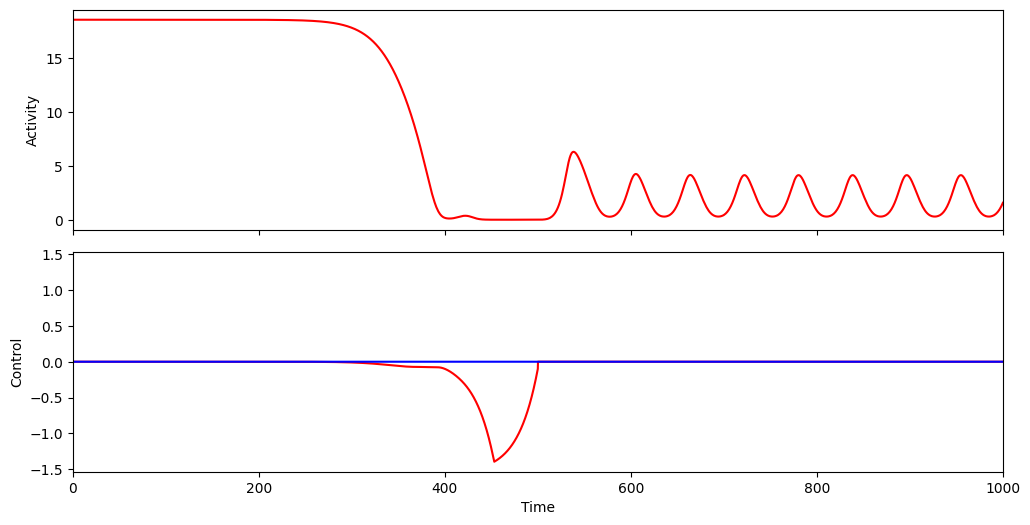

In [42]:
ci = 0 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][0])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]
model_controlled.maximum_control_strength = max_cntrl

for k in [0,4]:
    model_controlled.zero_step_encountered = False
    model_controlled.step = 10**(k)
    model_controlled.optimize(2)

for k in np.arange(-4., 0., 1.):
    data["weights"][ci] = adjust_weight(model_controlled, data["weights"][ci])
    model_controlled.zero_step_encountered = False
    model_controlled.step = 10**(k)
    model_controlled.optimize(2)

data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

data["energy_input"][ci] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost"][ci] = (model_controlled.compute_total_cost() - data["energy_input"][ci])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

In [ ]:
# rerun until convergence
ci = 0 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][0])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]

model_controlled.maximum_control_strength = max_cntrl

model_controlled.control = data["control"][ci].copy()
model_controlled.update_input()
model_controlled.optimize(1)

for j in range(100):
    data["weights"][ci] = adjust_weight(model_controlled, data["weights"][ci])

    model_controlled.grad_method = 0
    for k in np.arange(-4., 5., 2.): 
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    model_controlled.grad_method = 1
    for k in np.arange(-4., 5., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    if cost_functions.control_strength_cost(model_controlled.control, weights, dt) > 1e-2:
        data["control"][ci] = model_controlled.control.copy()
        data["state"][ci] = model_controlled.get_xs()

data["energy_input"][ci] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost"][ci] = (model_controlled.compute_total_cost() - data["energy_input"][0])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)
print("energy input = ", data["energy_input"][ci])

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -4.8499565709445025e-05
Converged in iteration 1 with cost -4.8499565709445025e-05
Final cost : -4.8499565709445025e-05
weight =  0.048886795811580674
Compute control for a deterministic system
Cost in iteration 0: -9.999986949615902e-13
Converged in iteration 1 with cost -9.999986949615902e-13
Final cost : -9.999986949615902e-13
Compute control for a deterministic system
Cost in iteration 0: -9.999986949615902e-13
Converged in iteration 1 with cost -9.999986949615902e-13
Final cost : -9.999986949615902e-13
Compute control for a deterministic system
Cost in iteration 0: -9.999986949615902e-13
Converged in iteration 1 with cost -9.999986949615902e-13
Final cost : -9.999986949615902e-13
Compute control for a deterministic system
Cost in iteration 0: -9.999986949615902e-13
Converged in iteration 1 with cost -9.999986949615902e-13
Final cost : -9.999986949615902e-13
Compute contro

In [ ]:
energy input =  0.04167601306274485

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.0030703485105282105
Final cost : 0.0030703485105282105
weight =  0.048944054756615826
Compute control for a deterministic system
Cost in iteration 0: -9.999986949615902e-13
Converged in iteration 1 with cost -9.045889037828658e-13
Final cost : -9.045889037828658e-13
Compute control for a deterministic system
Cost in iteration 0: -9.045889037828658e-13
Converged in iteration 1 with cost -9.045889037828658e-13
Final cost : -9.045889037828658e-13
Compute control for a deterministic system
Cost in iteration 0: -9.045889037828658e-13
Converged in iteration 1 with cost -9.045889037828658e-13
Final cost : -9.045889037828658e-13
Compute control for a deterministic system
Cost in iteration 0: -9.045889037828658e-13
Converged in iteration 2 with cost -4.8499565709445025e-05
Final cost : -4.8499565709445025e-05
Compute control for a deterministic system
Cost in iteration 0: -4.84995657

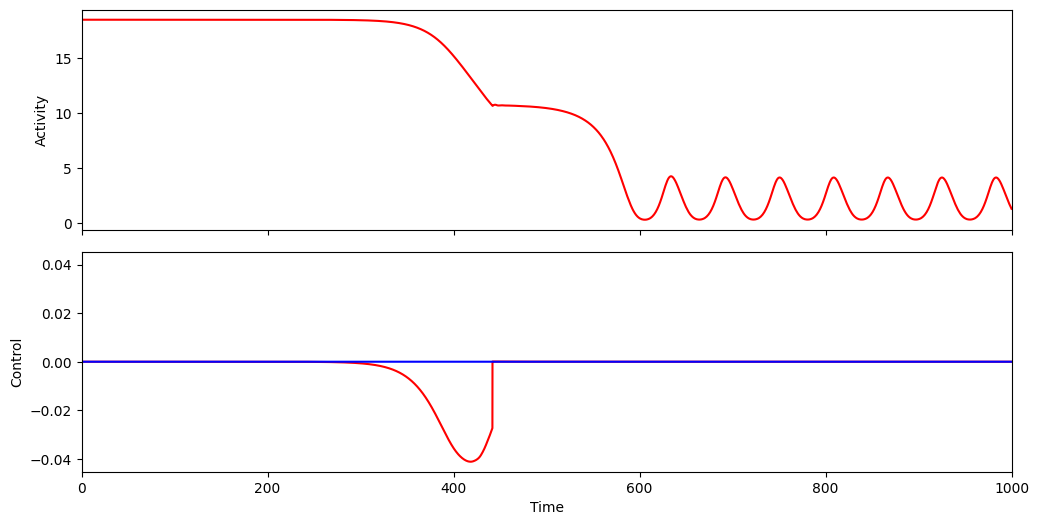

In [54]:
# shift back in time by 2 periods and re-optimize
ci = 0 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][0])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]

model_controlled.maximum_control_strength = max_cntrl

shift_ind = int(1*natural_period/dt)
model_controlled.control[0,0,:-shift_ind] =  data["control"][ci].copy()[0,0,shift_ind:]
model_controlled.update_input()
model_controlled.optimize(0)

for j in range(1):
    data["weights"][ci] = adjust_weight(model_controlled, data["weights"][ci])
    
    model_controlled.grad_method = 0
    for k in np.arange(-5., 6., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    model_controlled.grad_method = 1
    for k in np.arange(-5., 6., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

data["energy_input"][0] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost"][0] = (model_controlled.compute_total_cost() - data["energy_input"][0])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

In [50]:
with open(os.path.join(datadir, '3_2_1.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [55]:
print("energy input = ", data["energy_input"][ci])

energy input =  0.04140817326250786
